In [1]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import imageio
import os
from tqdm import trange
from sklearn.manifold import TSNE

(0.0, 79.0)

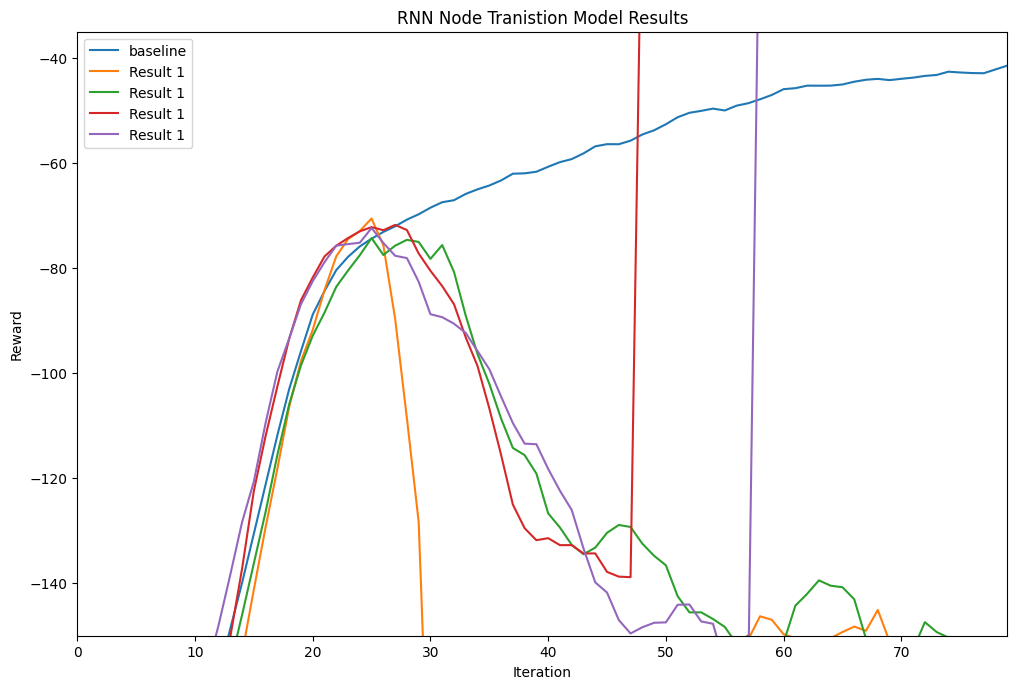

In [4]:
fig = plt.figure(figsize=(12, 8), dpi=100)
plt.plot(np.load('ppo_bline_baseline.npy'), label="baseline")
#plt.plot(np.load('node_priv_unk_lstm0.npy'), label="loss fix0")
#plt.plot(np.load('node_priv_unk_lstm1.npy'), label="loss fix1")
#plt.plot(np.load('node_priv_unk_lstm2.npy'), label="loss fix2")
#plt.plot(np.load('node_priv_unk_lstm3.npy'), label="loss fix3")

#plt.plot(np.load('node_feedforward_seq_reward0.npy'), label="node_state_action_reward0")
#plt.plot(np.load('node_feedforward_seq_reward1.npy'), label="node_state_action_reward0")

plt.plot(np.load('pred_fix0.npy'), label="Result 1")
plt.plot(np.load('pred_fix1.npy'), label="Result 1")
plt.plot(np.load('pred_fix2.npy'), label="Result 1")
plt.plot(np.load('pred_fix3.npy'), label="Result 1")
#plt.plot(np.load('node_id_branch2.npy'), label="Result 2")
#plt.plot(np.load('node_id_branch3.npy'), label="Result 3")
#plt.plot(np.load('node_id_branch4.npy'), label="Result 4")
#plt.plot(np.load('node_validation1.npy'), label="Result 5")

#plt.plot(np.load('node_state_action_reward3.npy'), label="node_state_action_reward3")
#plt.plot(np.load('node_priv_unk_lstm5.npy'), label="loss fix5")
#plt.plot(np.load('node_priv_unk_lstm6.npy'), label="loss fix6")

plt.legend()
plt.title('RNN Node Tranistion Model Results')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.ylim(-150, -35)
plt.xlim(0, 79)

In [1]:
mean_ = []
mean_.append(np.load('node_with_priv0.npy'))
mean_.append(np.load('node_with_priv1.npy'))
mean_.append(np.load('node_with_priv2.npy'))
mean_.append(np.load('node_with_priv3.npy'))
mean_ = np.array(mean_)
mean_ = np.mean(mean_, axis=1)
mean_

NameError: name 'np' is not defined

In [8]:
from os import listdir
from os.path import isfile, join
path = '/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/MBPPO/batch_encodings/'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
batches = {}
for f in onlyfiles:
    index = int(f.split('_')[-1].split('.')[0])
    if f.split('_')[0] == 'dream': index += 1
    batches[index] = np.load(path + f)

keys = list(batches.keys())
keys.sort()
batches = {i: batches[i] for i in keys}

real_map = []; dream_map = []
for i, k in enumerate(list(batches.keys())):
    if k % 2 == 0:
        real_map.append(i)
    else:
        dream_map.append(i)
batch_array = np.array((list(batches.values())))

real_map_array = np.array(real_map, dtype=np.int16)
dream_map_array = np.array(dream_map, dtype=np.int16)

In [9]:
#reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
#embedding = reducer.fit_transform(batch_array)
embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(batch_array[:,:])

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7fcd067570d0>
Traceback (most recent call last):
  File "/home/adamprice/miniconda3/envs/u75a/lib/python3.8/site-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/adamprice/miniconda3/envs/u75a/lib/python3.8/site-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/home/adamprice/miniconda3/envs/u75a/lib/python3.8/site-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/home/adamprice/miniconda3/envs/u75a/lib/python3.8/site-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/home/adamprice/miniconda3/envs/u75a/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _d

In [10]:
real_m = list(np.arange(40))
dream_m = []
for i in range(40,120):
    if i % 2 == 0:
        real_m.append(i)
    else:
        dream_m.append(i)

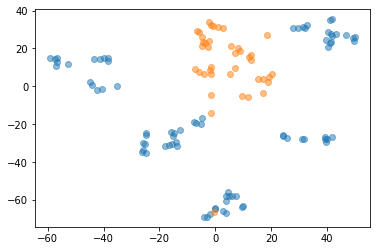

In [11]:

plt.scatter(embedding[real_m][:,0], embedding[real_m][:,1], alpha=0.5, label = 'Real')
plt.scatter(embedding[dream_m][:,0], embedding[dream_m][:,1], alpha=0.5, label = 'Dream')
    

In [12]:
path = '/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/MBPPO/batch_encodings/'
print('Spread from Real:')
cate = ['exploit', 'scan', 'no_activity', 'privileged', 'user', 'unknown', 'no comp']
a = np.load(path+'/obs_104000.npy')
for i in range(7):
    print(cate[i], np.mean(np.abs(a[np.arange(i,91,step=7)])))


Spread from Real:
exploit 0.01230769
scan 0.04626923
no_activity 0.94142306
privileged 0.006153846
user 0.103269234
unknown 0.034538463
no comp 0.85603845


In [13]:
print('Spread from Dream:')
cate = ['exploit', 'scan', 'no_activity', 'privileged', 'user', 'unknown', 'no comp']
a = np.load(path+'/dream_obs_104000.npy')
for i in range(7):
    print(cate[i], np.mean(np.abs(a[np.arange(i,91,step=7)])))

Spread from Dream:
exploit 0.013443223443223446
scan 0.038315018315018316
no_activity 0.9490476190476193
privileged 0.0012454212454212454
user 0.07542124542124543
unknown 0.02435897435897436
no comp 0.8995604395604395


In [469]:
np.set_printoptions(suppress=True)


In [9]:

path = 'gagif'
if not os.path.exists('gagif'):
    os.mkdir(path)
#Comment out umap_embedding if adjusting plots after first run, its non-determeisitic 

obs_based_reward = np.load('node_priv_unk_lstm0.npy')

dream_pnt = 0; real_pnt = 0
filenames = []
for i in trange(batch_array.shape[0]): 
    fig = plt.figure(figsize=(12, 8), dpi=100)
    
    ax = plt.subplot(1, 2, 1)
    ax.set_xlim([embedding[:,0].min()-2,embedding[:,0].max()+2])
    ax.set_ylim([embedding[:,1].min()-2,embedding[:,1].max()+2]) 
    ax.set_title('t-SNE plot of Batch Observation Embedding')
    ax1 = plt.subplot(1, 2, 2)
    ax1.set_xlim([0,80])
    ax1.set_ylim([-80,-35])
    ax1.set_title('Reward Accumilation')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Reward')
    ax1.plot(obs_based_reward[:real_pnt], label="Node Based")
    plt.plot(np.load('ppo_bline_baseline.npy'), label="Model Free Baseline")
    #ax1.plot(evals_ppo[:i_line+1], label="PPO - Evaluation")
    ax1.legend(loc='lower right')

    if i in real_map:
        real_pnt += 1
    else:
        dream_pnt += 1

    ax.scatter(embedding[real_map_array[:real_pnt]][:,0], embedding[real_map_array[:real_pnt]][:,1], alpha=0.5, label = 'Real')
    ax.scatter(embedding[dream_map_array[:dream_pnt]][:,0], embedding[dream_map_array[:dream_pnt]][:,1], alpha=0.5, label = 'Dream')
    ax.legend()
    plt.savefig(path+'/'+str(i)+'.png')
    filenames.append(path+'/'+str(i)+'.png')
    plt.close()

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('worldmodel_training.gif', images, duration=0.2)

100%|██████████| 120/120 [00:47<00:00,  2.54it/s]


In [451]:
imageio.mimsave('worldmodel_training.gif', images, duration=0.3)

In [9]:

path = 'gagif'
if not os.path.exists('gagif'):
    os.mkdir(path)
#Comment out umap_embedding if adjusting plots after first run, its non-determeisitic 

obs_based_reward = np.load('ppo_lstm1.npy')

dream_pnt = 0; real_pnt = 0
filenames = []
fig = plt.figure(figsize=(12, 8), dpi=100)

ax = plt.subplot(1, 2, 1)
ax.set_xlim([embedding[:,0].min()-2,embedding[:,0].max()+2])
ax.set_ylim([embedding[:,1].min()-2,embedding[:,1].max()+2]) 
ax.set_title('uMAP of Batch Observation Embedding')
ax1 = plt.subplot(1, 2, 2)
ax1.set_xlim([0,80])
ax1.set_ylim([-80,-35])
ax1.set_title('Reward Accumilation')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Reward')
ax1.plot(obs_based_reward[:real_pnt], label="Node Based")
#ax1.plot(evals_ppo[:i_line+1], label="PPO - Evaluation")
ax1.legend(loc='lower right')


ax.scatter(embedding[real_map_array][:,0], embedding[real_map_array][:,1], alpha=0.5, label = 'Real')
ax.scatter(embedding[dream_map_array][:,0], embedding[dream_map_array][:,1], alpha=0.5, label = 'Dream')
ax.set_xlim([np.min(embedding[:,0])-1,np.max(embedding[:,0])+1])
ax.set_ylim([np.min(embedding[:,1])-1,np.max(embedding[:,1])+1])
ax.legend()

for i, txt in enumerate(dream_map_array):
    ax.annotate(txt, (embedding[dream_map_array][i,0], embedding[dream_map_array][i,1]))

for i, txt in enumerate(real_map_array):
    ax.annotate(txt, (embedding[real_map_array][i,0], embedding[real_map_array][i,1]))


FileNotFoundError: [Errno 2] No such file or directory: 'ppo_lstm1.npy'

In [88]:
np.arange(4,91,step=7)

array([ 4, 11, 18, 25, 32, 39, 46, 53, 60, 67, 74, 81, 88])

In [207]:
from ray.rllib.utils.replay_buffers import ReplayBuffer, StorageUnit 
from ray.rllib.policy.sample_batch import SampleBatch 

buffer = ReplayBuffer(capacity=100)
dummy_batch = SampleBatch({"a": np.arange(100)})
buffer.add(dummy_batch)
s = buffer.sample(100)['a']
s
#for i in range(100):
#    print(np.where(s==i))

array([93, 19,  4, 92, 20, 81, 42, 21, 70, 51, 35,  6, 26, 37, 33, 93, 33,
       77, 80,  7, 27, 46, 23, 47, 59, 57, 26, 57, 31, 77,  7, 67,  9, 20,
       21, 94, 99, 73, 35, 25, 66, 13, 91, 31, 62, 23, 47, 98, 71, 68, 55,
       20, 80,  3, 60, 31,  5, 29, 24, 86, 71, 14, 36, 57, 34, 23, 53, 19,
       38, 62, 34, 68,  3, 23, 18, 92, 73,  4, 31,  6, 47, 60, 97, 35, 87,
        0, 13, 80, 94, 85,  4, 44,  3, 86,  1,  1, 58, 62,  7, 13])

In [34]:
dream =  np.load('random_walks_dream.npy').mean(axis=1)
real = np.load('random_walks_real.npy').mean(axis=1)
print('Spread from Dream:')
cate = ['exploit', 'scan', 'no_activity', 'privileged', 'user', 'unknown', 'no comp']
a = dream.mean(axis=0)
for i in range(7):
    print(cate[i], np.mean(np.abs(a[np.arange(i,91,step=7)])))

Spread from Dream:
exploit 0.004538461538461539
scan 0.03746153846153847
no_activity 0.9580000000000001
privileged 0.059807692307692326
user 0.05492307692307692
unknown 0.036000000000000004
no comp 0.8492692307692309


In [35]:
print('Spread from real:')
cate = ['exploit', 'scan', 'no_activity', 'privileged', 'user', 'unknown', 'no comp']
a = real.mean(axis=0)
for i in range(7):
    print(cate[i], np.mean(np.abs(a[np.arange(i,91,step=7)])))

Spread from real:
exploit 0.003800000000000002
scan 0.042815384615384595
no_activity 0.9533846153846155
privileged 0.0998923076923077
user 0.0687923076923077
unknown 0.10006923076923079
no comp 0.7312461538461539


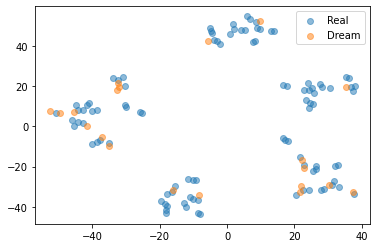

In [36]:
dream =  np.load('random_walks_dream.npy').mean(axis=1)
real = np.load('random_walks_real.npy').mean(axis=1)
all = np.concatenate([dream, real], axis=0)

embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(all)

plt.scatter(embedding[:100][:,0], embedding[:100][:,1], alpha=0.5, label = 'Real')
plt.scatter(embedding[100:][:,0], embedding[100:][:,1], alpha=0.5, label = 'Dream')
plt.legend()

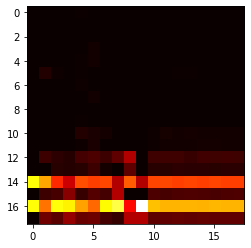

In [38]:

plt.imshow(np.load('reward_matrix_lstm.npy'), cmap='hot', interpolation='nearest')

In [9]:
reward_to_index = np.load('/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/MBPPO/reward_to_index.npy', allow_pickle=True).item()
index_to_reward = np.load('/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/MBPPO/index_to_reward.npy', allow_pickle=True).item()

In [13]:
index_to_reward[reward_to_index[-0.10000000149011612]]

-0.10000000149011612

In [14]:
data_path = '/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/Notebooks/logs/PPO/no_decoy_200000/data_seqence_50'
state = np.load(data_path + '/states.npy')
rewards = np.load(data_path + '/rewards.npy')

labels, encoding = np.unique(rewards, return_inverse=True)
index_to_reward = {}; reward_to_index = {}
for i in range(labels.shape[0]):
    index_to_reward[i] = labels[i]
    reward_to_index[labels[i]] = i

reward_classes = np.vectorize(reward_to_index.get)(rewards)
reward_onehot = np.eye(int(len(reward_to_index.keys())))[reward_classes]
print(reward_onehot.mean(axis=0))

[2.02020202e-04 1.31313131e-04 1.27777778e-03 7.42424242e-04
 3.19191919e-03 1.76767677e-03 7.42424242e-04 1.13131313e-03
 7.67676768e-04 8.33333333e-04 1.01818182e-02 9.28787879e-03
 5.41818182e-02 3.17222222e-02 3.08696970e-01 6.57373737e-02
 4.26106061e-01 8.32979798e-02]


In [67]:
!pip install mpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.3 MB/s eta 0:00:00


In [5]:
import mpu.ml
one_hot = mpu.ml.indices2one_hot(reward_classes, nb_classes=18)

In [55]:
np.histogram(reward_classes, bins=np.arange(18))

(array([    40,     26,    253,    147,    632,    350,    147,    224,
           152,    165,   2016,   1839,  10728,   6281,  61122,  13016,
        100862]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]))

In [7]:
mean = np.array(reward_onehot).mean(axis=0)
for i in range(18):
    print(mean[i])

0.00020202020202020202
0.0001313131313131313
0.0012777777777777779
0.0007424242424242425
0.003191919191919192
0.0017676767676767678
0.0007424242424242425
0.0011313131313131313
0.0007676767676767677
0.0008333333333333334
0.010181818181818183
0.009287878787878788
0.054181818181818185
0.03172222222222222
0.3086969696969697
0.06573737373737373
0.4261060606060606
0.0832979797979798
